In [1]:
import numpy as np

from SemiNbody2 import Simulation,Particle,Planet,ResonancePerturbation

import matplotlib.pyplot as plt
%matplotlib inline

# A basic integration

In [2]:
# Get a simulation object
sim = Simulation()

# intialize a structure to hold perturbing resonances
#  and add it to the simulation
rpert = ResonancePerturbation(mu=1e-5,mean_motion=1.5,ecc=.02)
rpert.add_multiplet(3,1,True)
sim.add_resonance_perturbation(rpert)

# initialize a particle
sim.add_particle(e=0.01)

# intialize a planetary perturber
sim.add_planet(mu=1e-5,a=(1.504)**(2/3))

# Set the timestep
sim.dt= 2*np.pi / 30 / 1.5 

In [3]:
Nout = 300
tfin = 3e3 * 2 * np.pi

times=np.linspace(0, tfin,Nout)
X,Y = np.zeros((2,Nout))
megno = np.zeros(Nout)
for i,t in enumerate(times):
    
    sim.integrate(t)
    
    particle = sim.particles[0]

    X[i]=particle.state.X
    Y[i]=particle.state.Y
    megno[i] = particle.megno.megno

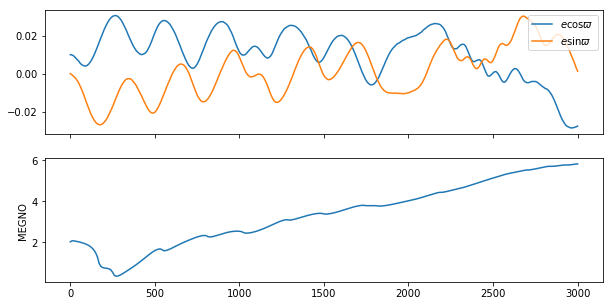

In [11]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(10,5))
TWO_PI=2*np.pi
ax[0].plot(times/TWO_PI,X,label=r"$e\cos\varpi$")
ax[0].plot(times/TWO_PI,Y,label=r"$e\sin\varpi$")
ax[0].legend(loc='upper right')
ax[1].plot(times/TWO_PI,megno)
ax[1].set_ylabel("MEGNO")

# A MEGNO grid

In [57]:
mu_in,mu_out = 1e-5,1e-5
def get_sim(pars):
    jin,jout = pars
    mean_motion_in = jin/(jin-1)
    lmbda_in=np.pi/3
    rpert = ResonancePerturbation(mu=mu_in,mean_motion=mean_motion_in,lmbda=lmbda_in,pomega=0.)
    rpert.add_multiplet(3,1,innerQ=True)
    sim = Simulation()
    a_out = (jout/(jout-1))**(2/3.)
    lmbda_out = np.pi/3.
    sim.add_planet(mu=mu_out,a=a_out,l=lmbda_out,e=0.,w=0)
    sim.add_particle(e=0.05,w=np.pi)
    sim.add_resonance_perturbation(rpert)
    sim.dt = 2*np.pi / 30 / mean_motion_in
    
    return sim

In [58]:
TFIN = 3e3 * TWO_PI 
def get_megno(pars):
    sim=get_sim(pars)
    sim.integrate(TFIN)
    return sim.particles[0].megno.megno

In [ ]:
Ngrid = 26
j_in=np.linspace(2.95,3.05,Ngrid)
j_out= 1 + np.linspace(2.75,3.55,Ngrid)
pars =[]
for jo in j_out:
    for ji in j_in:
        pars.append((ji,jo))

from rebound.interruptible_pool import InterruptiblePool
pool=InterruptiblePool()

results = pool.map_async(get_megno,pars)
results = results.get()

In [ ]:
results2d=np.array(results).reshape(Ngrid,Ngrid)
extent=[np.min(j_in),np.max(j_in),np.min(j_out),np.max(j_out)]
fig,ax = plt.subplots(1,figsize=(10,10))
ax.imshow(results2d,vmin=1.9,vmax=5,interpolation="none",cmap="RdYlGn_r",extent=extent,aspect='auto')
ax.set_xlabel('$J_{in}$')
ax.set_ylabel('$J_{out}$')